In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import json

from transformers import RobertaModel, AutoTokenizer

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from itertools import cycle

from matplotlib import pyplot as plt

import math
import torch
import random

In [3]:
np.random.seed(42)
torch.manual_seed(0)
random.seed(0)

In [4]:
TRAIN = "prepared_data/train.csv"
TEST = "prepared_data/test.csv"

In [5]:
train = pd.read_csv(TRAIN)

In [6]:
train

,library,fname,features,is_uart,is_spi,is_i2c,is_none,len_features,label
0,GT5X,GT5X,"void GT5X::write_cmd_packet(uint16_t cmd, uint...",1,0,0,0,924,1
1,MH-Z19,MHZ19,void MHZ19::begin(Stream &serial){mySerial = &...,1,0,0,0,791,1
2,Pixetto,Pixetto,"Pixetto::Pixetto(int rx, int tx){m_rx = rx;m_t...",1,0,0,0,354,1
3,TriSonica_Mini,TSM,TSM::TSM(HardwareSerial& stream) {_serial = &s...,1,0,0,0,218,1
4,LSA08,DebuggerSerial,DebuggerSerial::DebuggerSerial() {}[SEP]Debugg...,1,0,0,0,153,1
...,...,...,...,...,...,...,...,...,...
300,Arduino_APA102,Arduino_APA102,Arduino_APA102::Arduino_APA102(uint8_t newNumL...,0,0,0,1,297,4
301,FastCapacitiveSensor,FastCapacitiveSensor,FastCapacitiveSensor::FastCapacitiveSensor() {...,0,0,0,1,129,4
302,DHTINT,dhtint,"void DHTINT::reset(){pinMode(_dataPin, OUTPUT)...",0,0,0,1,342,4
303,CurrentTransformer,CurrentTransformer,"CT_Sensor::CT_Sensor(uint8_t channel, float ra...",0,0,0,1,269,4


In [7]:
train.is_uart.sum()

19

In [8]:
train.is_i2c.sum()

159

In [9]:
train.is_none.sum()

98

In [10]:
train.is_spi.sum()

45

In [11]:
test = pd.read_csv(TEST)
test

,library,fname,features,is_uart,is_spi,is_i2c,is_none,len_features,label
0,MH-Z19,MHZ19,"MHZ19::MHZ19(byte SDA, byte SDL, byte addr) : ...",1,0,0,0,945,1
1,PMSensor-HPMA115,HPMA115_Compact,HPMA115_Compact::HPMA115_Compact() {}[SEP]bool...,1,0,0,0,308,1
2,AmbientCO2,AmbientCO2,AmbientCO2::AmbientCO2(Stream &serialPort) {_s...,1,0,0,0,54,1
3,DFRobot_BT401,DFRobot_BT401,DFRobot_BT401::DFRobot_BT401(){}[SEP]bool DFRo...,1,0,0,0,251,1
4,ALog,ALog,ALog::ALog(){}[SEP]void ALog::initialize(char*...,1,1,1,0,2306,1
...,...,...,...,...,...,...,...,...,...
165,Analog-Keypad,ezAnalogKeypad,ezAnalogKeypad::ezAnalogKeypad(int pin) {keypa...,0,0,0,1,171,4
166,PMsensor,PMsensor,PMsensor::PMsensor() {}[SEP]void PMsensor::ini...,0,0,0,1,71,4
167,arduino-volume1,Volume,void Volume::alternatePin(bool enabled) {if (e...,0,0,0,1,165,4
168,UltraSonic_Lib,UltraSonic,"UltraSonic::UltraSonic(int pintype, int pin_on...",0,0,0,1,107,4


In [12]:
test.is_uart.sum()

14

In [13]:
test.is_i2c.sum()

96

In [14]:
test.is_none.sum()

51

In [15]:
test.is_spi.sum()

48

# load models

In [16]:
MODEL_PATH = "models/codebert_all_updated8oct/checkpoint-150"
model = RobertaModel.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

Some weights of the model checkpoint at models/codebert_all_updated8oct/checkpoint-150 were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at models/codebert_all_updated8oct/checkpoint-150 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [17]:
# sample = train.iloc[0].features
# sample

In [18]:
# model_input = tokenizer(sample, return_tensors="pt", truncation=True, max_length=512, padding='max_length')

In [19]:
# with torch.no_grad():
#     # print(model(**model_input).pooler_output.numpy().tolist()[0])

# train

In [20]:
def get_labels(df):
    is_spi = df.is_spi.values
    is_uart = df.is_uart.values
    is_i2c = df.is_i2c.values
    is_none = df.is_none.values
    return np.column_stack((is_uart, is_spi, is_i2c, is_none))

def convert_to_vectors(x):
    model_input = tokenizer(x, return_tensors="pt", truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        return model(**model_input).pooler_output.numpy().tolist()[0]

In [21]:
train_labels = get_labels(train)

In [22]:
train_features_raw = train.features.progress_apply(lambda x: convert_to_vectors(x))
train_features = np.vstack(train_features_raw.values)

  0%|          | 0/305 [00:00<?, ?it/s]

In [23]:
train_features.shape, train_labels.shape

((305, 768), (305, 4))

In [24]:
test_labels = get_labels(test)

In [25]:
test_features_raw = test.features.progress_apply(lambda x: convert_to_vectors(x))
test_features = np.vstack(test_features_raw.values)

  0%|          | 0/170 [00:00<?, ?it/s]

In [26]:
test_features.shape, test_labels.shape

((170, 768), (170, 4))

In [27]:
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=0)
)

In [28]:
y_score = classifier.fit(train_features, train_labels).decision_function(test_features)

In [29]:
y_score.shape

(170, 4)

In [30]:
def compute_ROC(y_scores, y_labels, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [31]:
lw = 2
n_classes=4
fpr, tpr, roc_auc = compute_ROC(y_score, test_labels, 4)

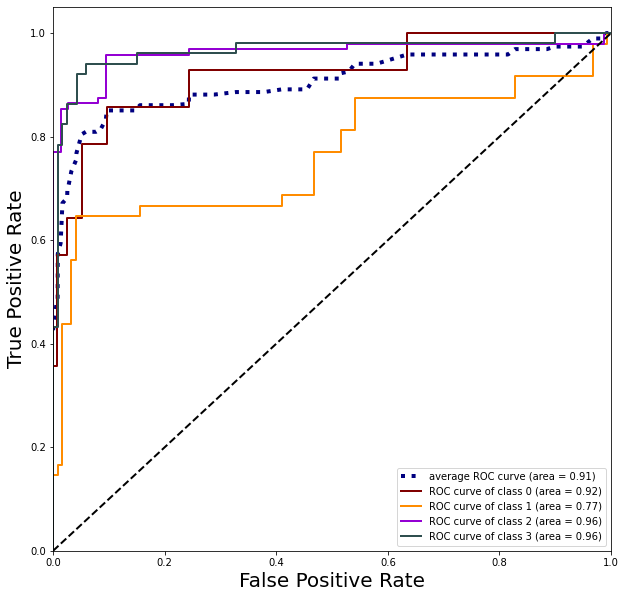

In [32]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["maroon", "darkorange", "darkviolet", 'darkslategray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize = 20)
# plt.title("SVM Results")
plt.legend(loc="lower right")
plt.show()

# classify real world queries

In [36]:
json_path = "prepared_data/real_world_queries_input.json"

In [37]:
with open(json_path, 'r') as f:
    queries = json.load(f)
    
queries = pd.DataFrame(queries)

In [38]:
test_labels = np.vstack(queries.label.values)

In [39]:
test_features_raw = queries.feature.progress_apply(lambda x: convert_to_vectors(x))
test_features = np.vstack(test_features_raw.values)

  0%|          | 0/290 [00:00<?, ?it/s]

In [40]:
test_features.shape, test_labels.shape

((290, 768), (290, 4))

In [41]:
y_score = classifier.decision_function(test_features)

In [42]:
n_labels = 4
lw = 2
fpr, tpr, roc_auc = compute_ROC(y_score, test_labels, 4)

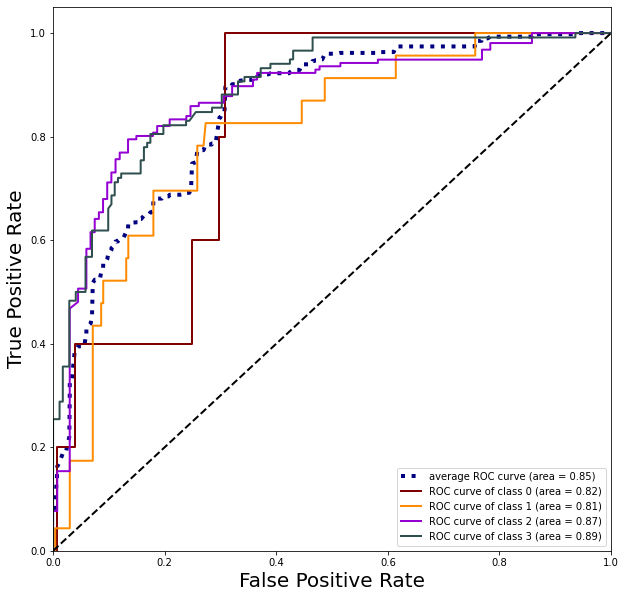

In [43]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["maroon", "darkorange", "darkviolet", 'darkslategray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize = 20)
# plt.title("SVM Results")
plt.legend(loc="lower right")
plt.show()